In [2]:
import pickle 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import xgboost as xgb
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler

from hyperopt import hp, fmin, tpe, Trials

import io
import os
from PIL import Image

import json

import holidays

In [3]:
dfs_to_merge = []

## Scraped Hourly Next-Day Energy Prices

In [5]:
e_price_df = pd.read_csv('../../data/day_ahead_energy_prices.csv', delimiter=",")[::-1]
e_price_df = e_price_df.set_index('Datetime')
e_price_df.index = pd.to_datetime(e_price_df.index)

e_price_df.rename(columns={"hourly day-ahead energy price": "Price"}, inplace=True)
dfs_to_merge.append(e_price_df)
e_price_df

,Price
Datetime,
2024-11-21 23:00:00,107.46
2024-11-21 22:00:00,122.90
2024-11-21 21:00:00,123.05
2024-11-21 20:00:00,131.33
2024-11-21 19:00:00,154.05
...,...
2018-10-01 04:00:00,47.59
2018-10-01 03:00:00,47.38
2018-10-01 02:00:00,51.41


### Analysis

              Price
count  53850.000000
mean      93.738508
std       97.655427
min     -500.000000
25%       36.710000
50%       63.245000
75%      111.545000
max      871.000000


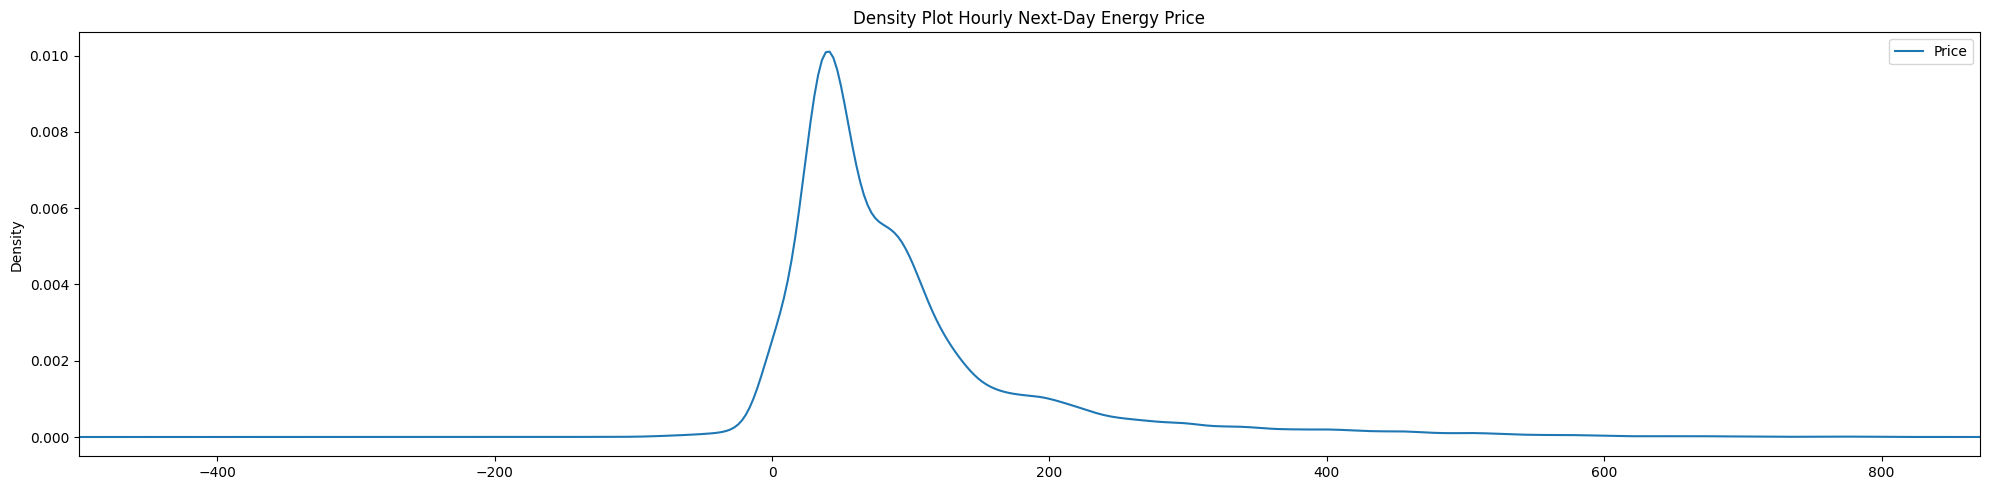

In [4]:
fig, ax = plt.subplots(figsize=(20, 5))
e_price_sorted = e_price_df.sort_values(by="Price", ignore_index=True).copy()

print(e_price_sorted.describe())

e_price_sorted.plot( ax = ax, kind = "density")
ax.set_xlim(-500, 871)
ax.set_ylabel("y")

ax.set_ylabel("Density")
ax.set_title("Density Plot Hourly Next-Day Energy Price")
fig.tight_layout()
plt.show()

## Scraped Hourly Energy Mix

In [5]:
mix_df = pd.read_csv('../../data/hourly_market_mix_cleaned.csv', delimiter=",")[::-1]
mix_df.set_index("Timestamp", inplace=True)
mix_df.index = pd.to_datetime(mix_df.index)
mix_df.rename_axis("Datetime", inplace=True) 
mix_df = mix_df.loc[:, mix_df.max() >= 0.01]
dfs_to_merge.append(mix_df)
mix_df


,Biomass,Hard Coal,Hydro,Lignite,Natural Gas,Nuclear,Other,Pumped storage generation,Solar,Wind offshore,Wind onshore
Datetime,,,,,,,,,,,
2024-10-30 00:00:00,0.101101,0.145455,0.045090,0.260219,0.243971,0.000000,0.049146,0.000022,0.0,0.047519,0.107476
2024-10-29 23:00:00,0.097725,0.149445,0.044872,0.274110,0.243789,0.000000,0.046156,0.000599,0.0,0.040935,0.102369
2024-10-29 22:00:00,0.095872,0.150584,0.047273,0.270704,0.255679,0.000000,0.046154,0.001140,0.0,0.035149,0.097447
2024-10-29 21:00:00,0.095560,0.150384,0.044436,0.265195,0.268427,0.000000,0.046835,0.002805,0.0,0.030024,0.096333
2024-10-29 20:00:00,0.093081,0.142999,0.047220,0.253702,0.278486,0.000000,0.044794,0.014459,0.0,0.027928,0.097331
...,...,...,...,...,...,...,...,...,...,...,...
2018-10-01 04:00:00,0.092527,0.148990,0.019701,0.282126,0.146368,0.138012,0.040888,0.003391,0.0,0.045451,0.082545
2018-10-01 03:00:00,0.093932,0.146157,0.020071,0.286085,0.153114,0.140053,0.041441,0.003452,0.0,0.039751,0.075943
2018-10-01 02:00:00,0.094656,0.139489,0.020001,0.286402,0.161350,0.142441,0.041791,0.003471,0.0,0.038929,0.071471


### Analysis

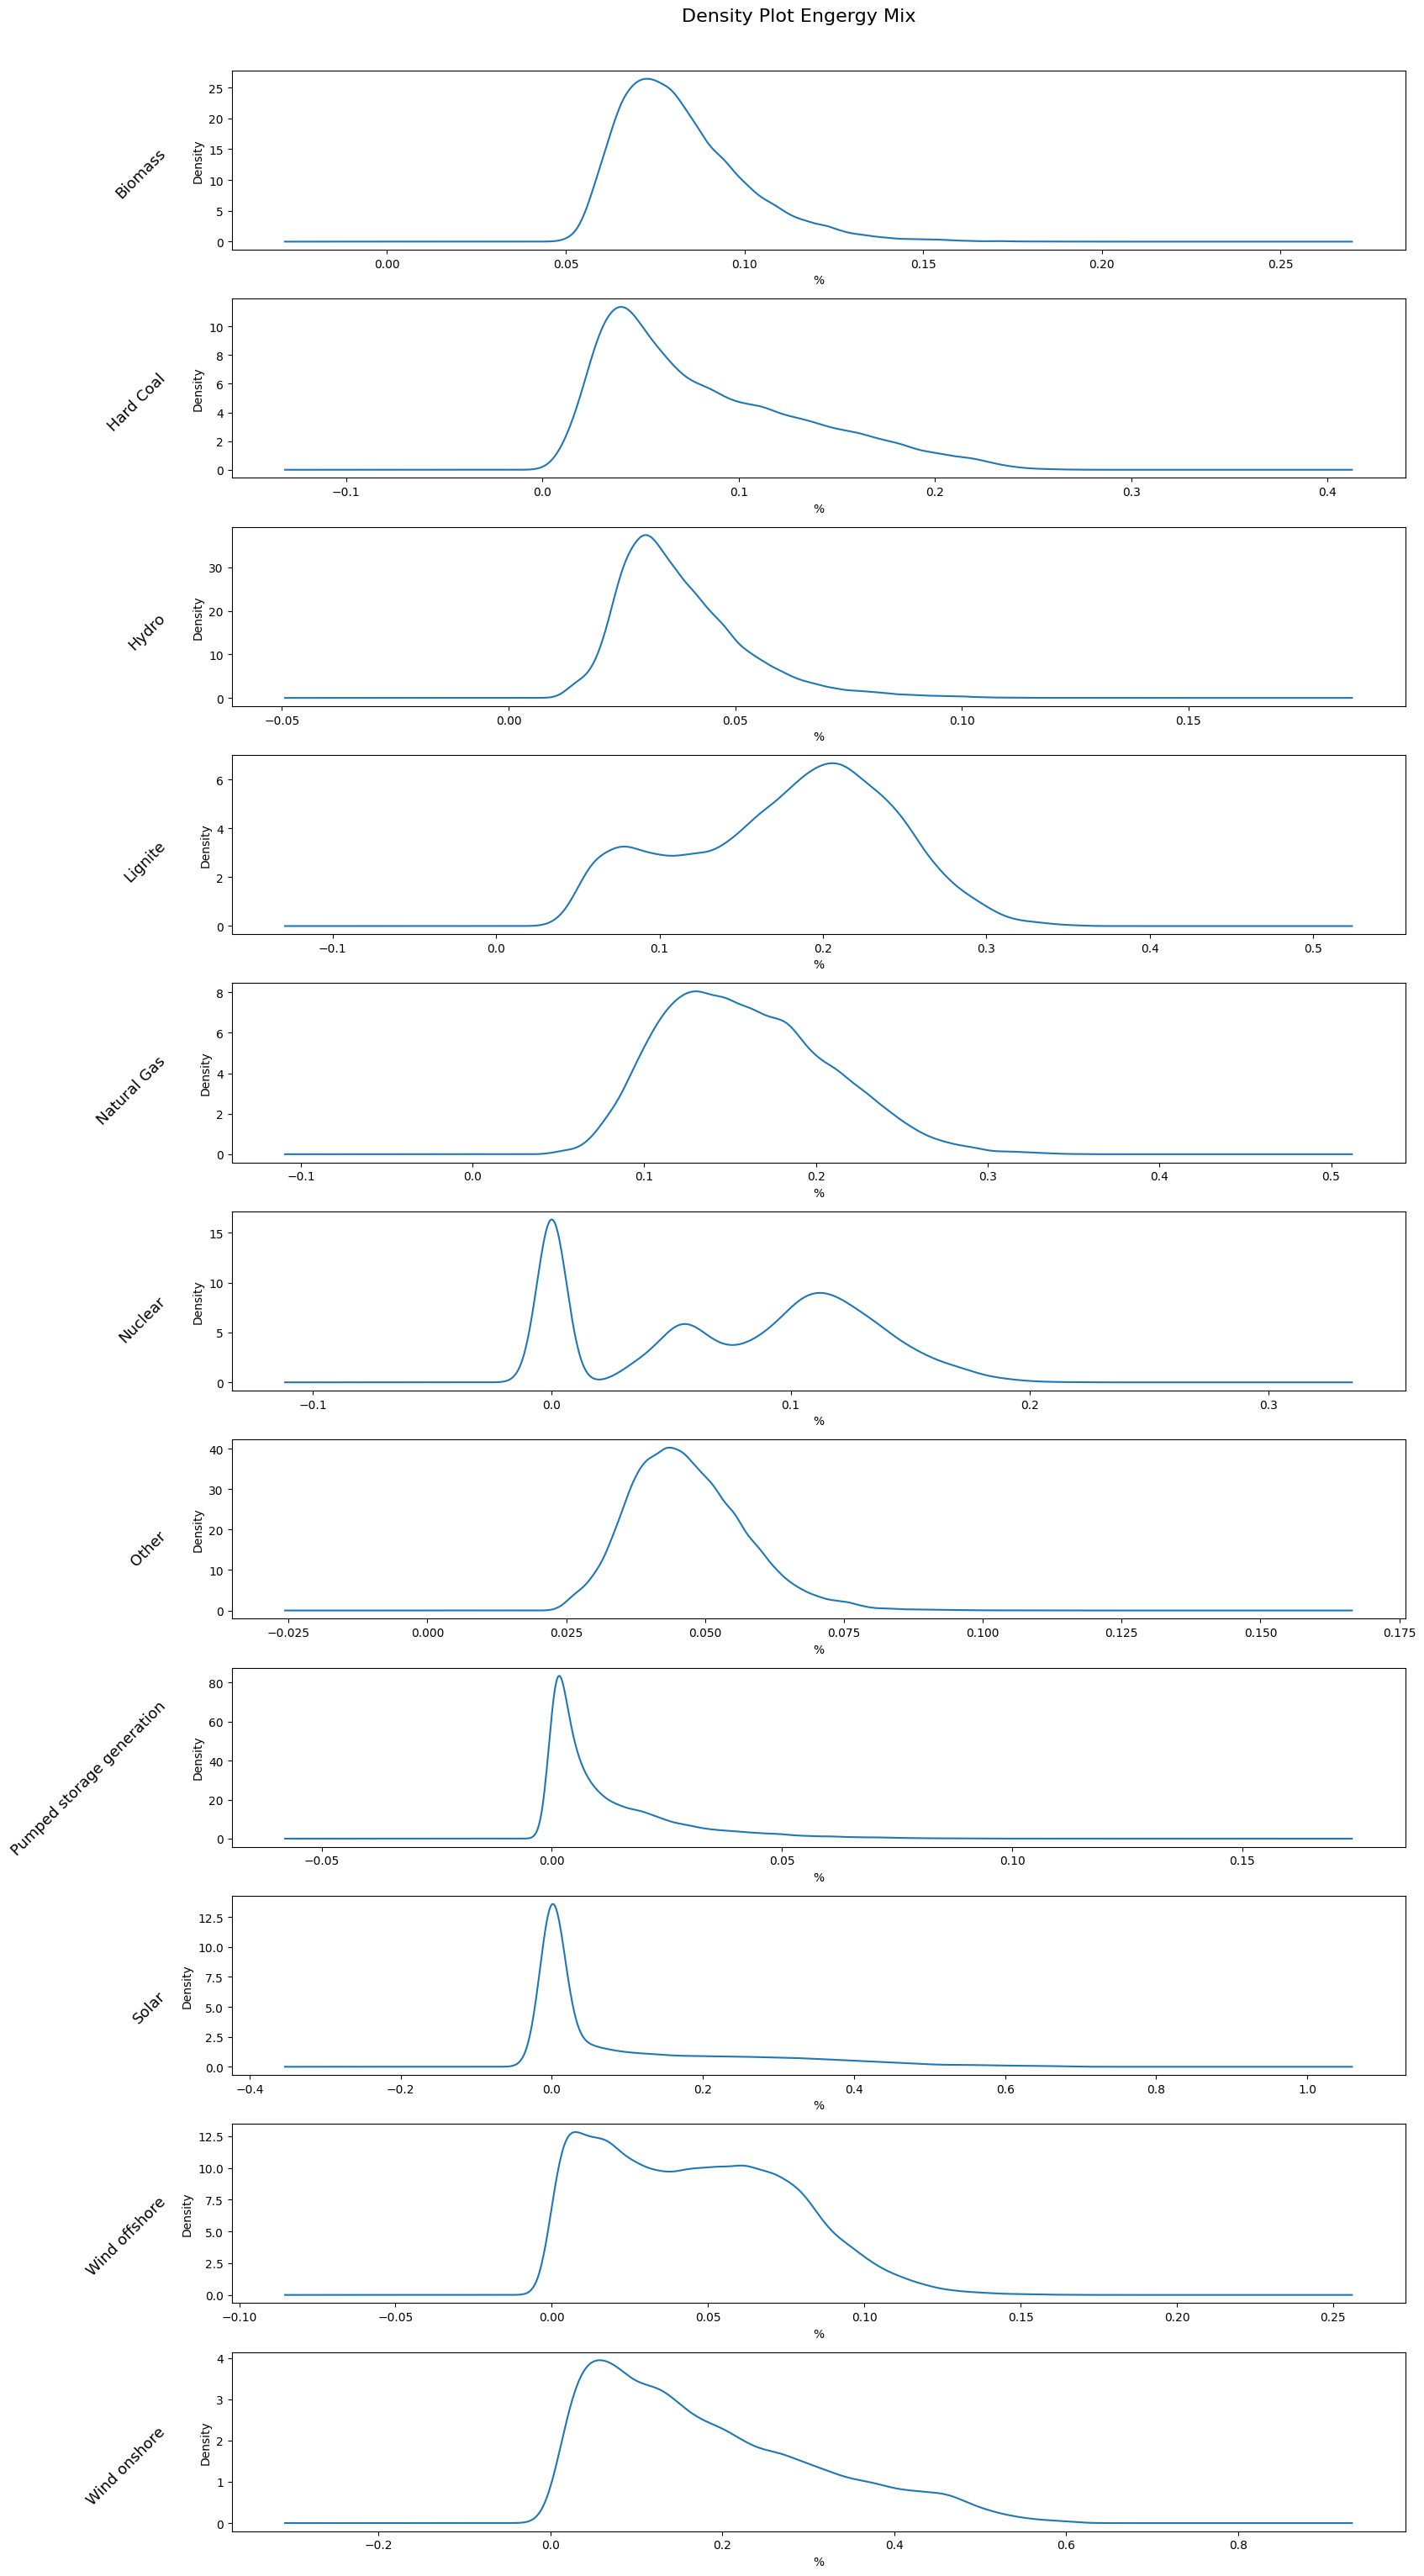

count    53161.000000
mean         0.082565
std          0.017816
min          0.046099
25%          0.069619
50%          0.079192
75%          0.091900
max          0.195352
Name: Biomass, dtype: float64 

count    53161.000000
mean         0.083275
std          0.051783
min          0.004782
25%          0.041829
50%          0.068767
75%          0.116213
max          0.276600
Name: Hard Coal, dtype: float64 

count    53161.000000
mean         0.038190
std          0.014154
min          0.009522
25%          0.028329
50%          0.035253
75%          0.045083
max          0.127235
Name: Hydro, dtype: float64 

count    53161.000000
mean         0.178598
std          0.063812
min          0.034065
25%          0.131726
50%          0.187467
75%          0.225959
max          0.360442
Name: Lignite, dtype: float64 

count    53161.000000
mean         0.159447
std          0.047908
min          0.046119
25%          0.122763
50%          0.154464
75%          0.191282
max          0

In [6]:
fig, axs = plt.subplots(11, figsize=(15, 30))
rows = 11

describe = []

for i, (cols_name, data) in enumerate(mix_df.items()):

    describe.append(data.describe())

    mix_sorted = data.sort_values(ignore_index=True).copy()

    mix_sorted.plot(ax = axs[i], kind = "density")

    axs[i].set_xlabel("%")

    y_pos = (rows - i - 0.5) / rows
    fig.text(0.0, y_pos, cols_name, ha='right', va='center', rotation=45, fontsize=13)


fig.tight_layout()
fig.suptitle("Density Plot Engergy Mix", fontsize=16, y=1.02)

plt.show()
for i in describe:
    print(i, "\n")

## Scraped Weather Forecast Data

In [7]:
weather_forecast_df = pd.read_csv("../../data/weather_forcast_prediciton.csv")[::-1]
weather_forecast_df.set_index("date" ,inplace=True)
weather_forecast_df.index = pd.to_datetime(weather_forecast_df.index)
weather_forecast_df.index = weather_forecast_df.index.tz_localize(None)
weather_forecast_df.rename_axis("Datetime",inplace=True)
weather_forecast_df.index = weather_forecast_df.index - pd.Timedelta(hours=24)

weather_forecast_df.rename(columns={
   # "temperature_2m": "pred_temperature_2m",
   "temperature_2m_previous_day1": "pred_temperature_2m_previous_day1",

   # "relative_humidity_2m": "pred_relative_humidity_2m",
   "relative_humidity_2m_previous_day1": "pred_relative_humidity_2m_previous_day1",

   # "precipitation": "pred_precipitation",
   "precipitation_previous_day1": "pred_precipitation_previous_day1",

   # "surface_pressure": "pred_surface_pressure",
   "surface_pressure_previous_day1": "pred_surface_pressure_previous_day1",

   # "shortwave_radiation": "pred_shortwave_radiation",
   "shortwave_radiation_previous_day1": "pred_shortwave_radiation_previous_day1",

   # "wind_speed_80m": "pred_wind_speed_80m",
   "wind_speed_80m_previous_day1": "pred_wind_speed_80m_previous_day1",

}, inplace=True)

# dfs_to_merge.append(weather_forecast_df)

weather_forecast_df

,pred_temperature_2m_previous_day1,pred_relative_humidity_2m_previous_day1,pred_precipitation_previous_day1,pred_surface_pressure_previous_day1,pred_shortwave_radiation_previous_day1,pred_wind_speed_80m_previous_day1
Datetime,,,,,,
2024-10-29 22:00:00,11.490999,9.490999,11.063000,9.613,11.113000,9.090000
2024-10-29 21:00:00,11.490999,9.790999,11.363000,10.013,11.363000,9.290000
2024-10-29 20:00:00,11.490999,9.591000,11.613000,10.263,11.863000,9.440001
2024-10-29 19:00:00,11.990999,10.091000,12.063000,10.563,12.513000,9.640000
2024-10-29 18:00:00,12.441000,11.040999,12.662999,10.813,13.212999,9.990001
...,...,...,...,...,...,...
2018-05-04 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-04 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-04 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN


### Analysis

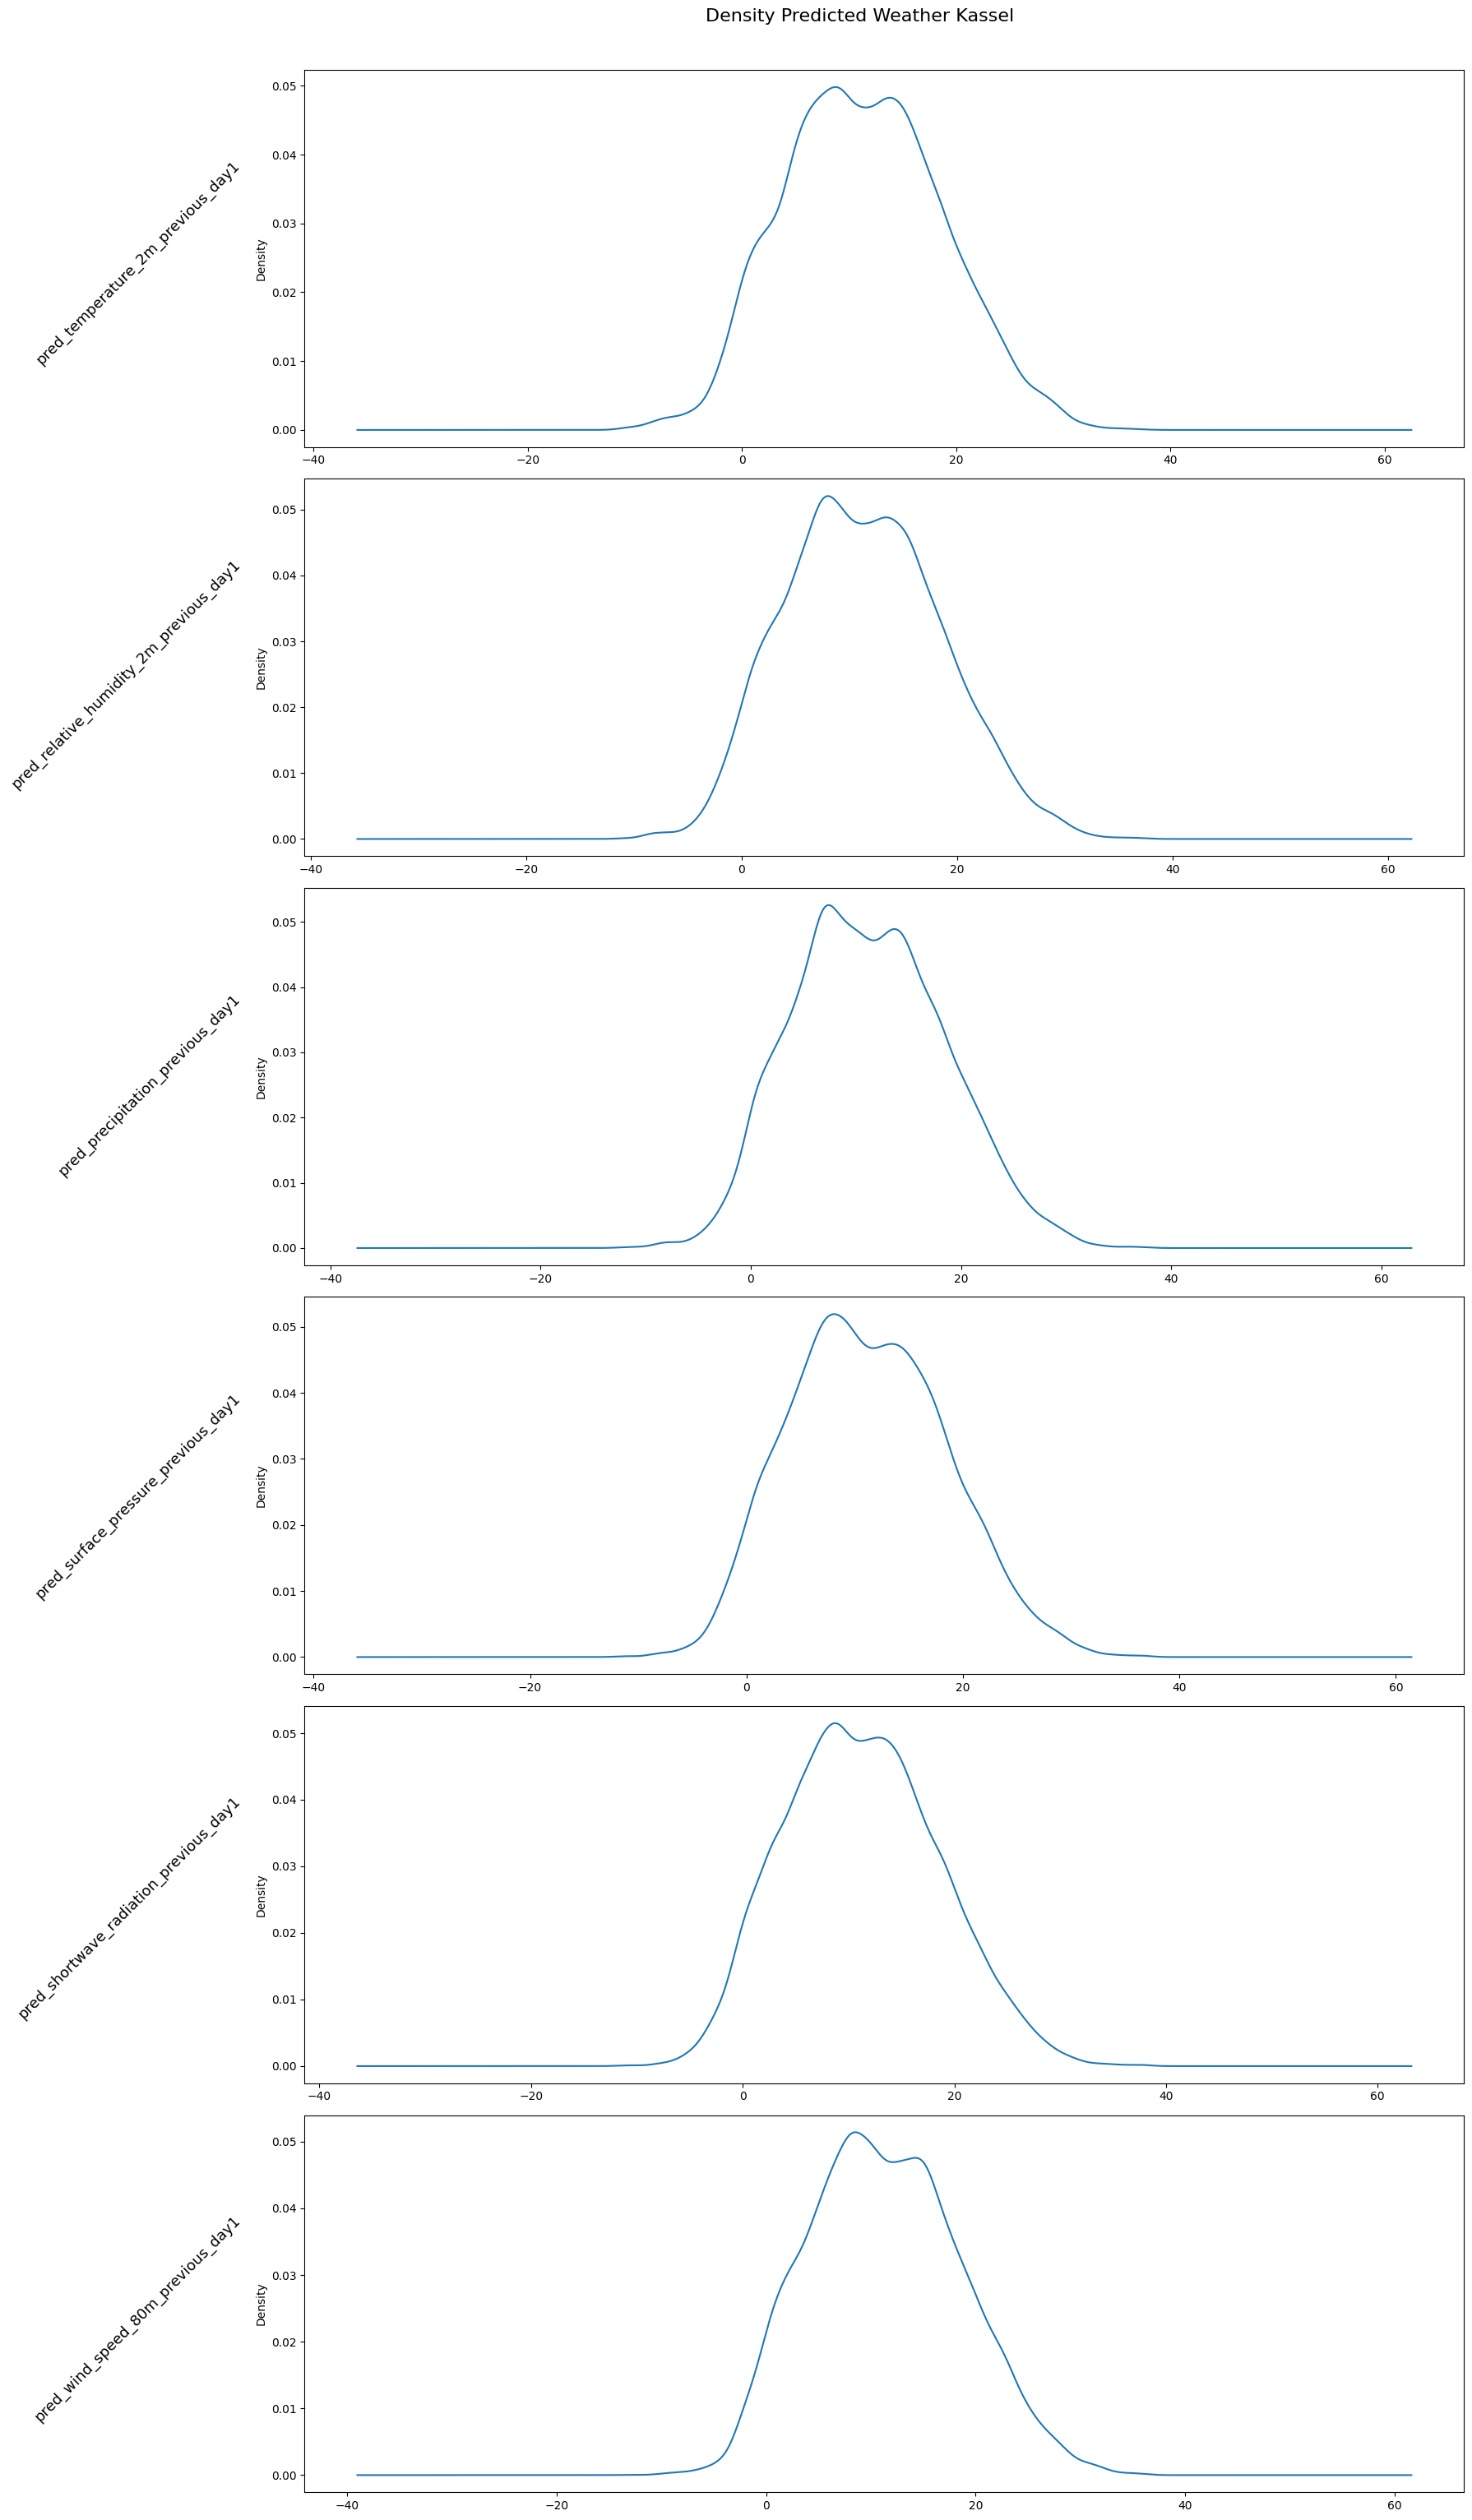

count    31631.000000
mean        11.343993
std          7.371119
min        -11.309000
25%          5.989500
50%         11.091000
75%         16.441000
max         37.889500
Name: pred_temperature_2m_previous_day1, dtype: float64 

count    31115.000000
mean        11.289670
std          7.200385
min        -11.210500
25%          6.039500
50%         11.040999
75%         16.265250
max         37.689503
Name: pred_relative_humidity_2m_previous_day1, dtype: float64 

count    31067.000000
mean        11.265342
std          7.198436
min        -12.360499
25%          6.089500
50%         10.962999
75%         16.289500
max         37.789500
Name: pred_precipitation_previous_day1, dtype: float64 

count    31019.000000
mean        11.236968
std          7.203261
min        -11.610499
25%          5.963000
50%         10.889501
75%         16.289500
max         37.089500
Name: pred_surface_pressure_previous_day1, dtype: float64 

count    30971.000000
mean        11.261677
std          

In [8]:
rows = 6
fig, axs = plt.subplots(rows, figsize=(15, 30))
describe = []
for i, (cols_name, data) in enumerate(weather_forecast_df.items()):

    describe.append(data.describe())
    forecast_sorted = data.sort_values(ignore_index=True).copy()

    forecast_sorted.plot(ax = axs[i], kind = "density")

    if forecast_sorted.min() == 0.0:
        axs[i].set_xlim(0)

    y_pos = (rows - i - 0.5) / rows
    fig.text(0.0, y_pos, cols_name, ha='right', va='center', rotation=45, fontsize=13)


fig.tight_layout()
fig.suptitle("Density Predicted Weather Kassel", fontsize=16, y=1.02)

plt.show()
for i in describe:
    print(i, "\n")

## Scraped Actual Weather Data

In [9]:
daily_weather_df = pd.read_csv('../../data/daily_weather.csv', delimiter=",")

daily_weather_df.set_index('date', inplace=True)
daily_weather_df.index = pd.to_datetime(daily_weather_df.index)

daily_weather_df.index = daily_weather_df.index.tz_localize(None)

daily_weather_df.rename(columns={
    'Precipitation (rain/snow)': 'precipitation',
    'wind_speed_100m': 'wind_speed_100m',
    'Global Horizontal Irradiance': 'shortwave_radiation',
    'direct_radiation': 'direct_radiation', 
    }, inplace=True)

dfs_to_merge.append(daily_weather_df)
daily_weather_df


,temperature_2m,relative_humidity_2m,precipitation,surface_pressure,cloud_cover,wind_speed_100m,sunshine_duration,shortwave_radiation,direct_radiation
date,,,,,,,,,
2018-01-01 00:00:00,10.007,72.08582,0.1,962.85810,100.0,44.946686,0.0,0.0,0.0
2018-01-01 01:00:00,9.107,78.18726,0.5,963.12980,99.0,36.797560,0.0,0.0,0.0
2018-01-01 02:00:00,8.057,86.00295,0.8,963.38170,97.0,33.895490,0.0,0.0,0.0
2018-01-01 03:00:00,7.357,88.34976,1.2,963.87006,100.0,36.589180,0.0,0.0,0.0
2018-01-01 04:00:00,7.007,83.81951,0.4,964.30660,95.0,37.842830,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2024-11-21 19:00:00,-2.243,78.99428,0.0,955.57263,100.0,25.283434,0.0,0.0,0.0
2024-11-21 20:00:00,-2.343,79.58027,0.0,955.65520,100.0,25.821060,0.0,0.0,0.0
2024-11-21 21:00:00,-1.293,74.78562,0.0,955.79816,100.0,25.837994,0.0,0.0,0.0


### Analysis

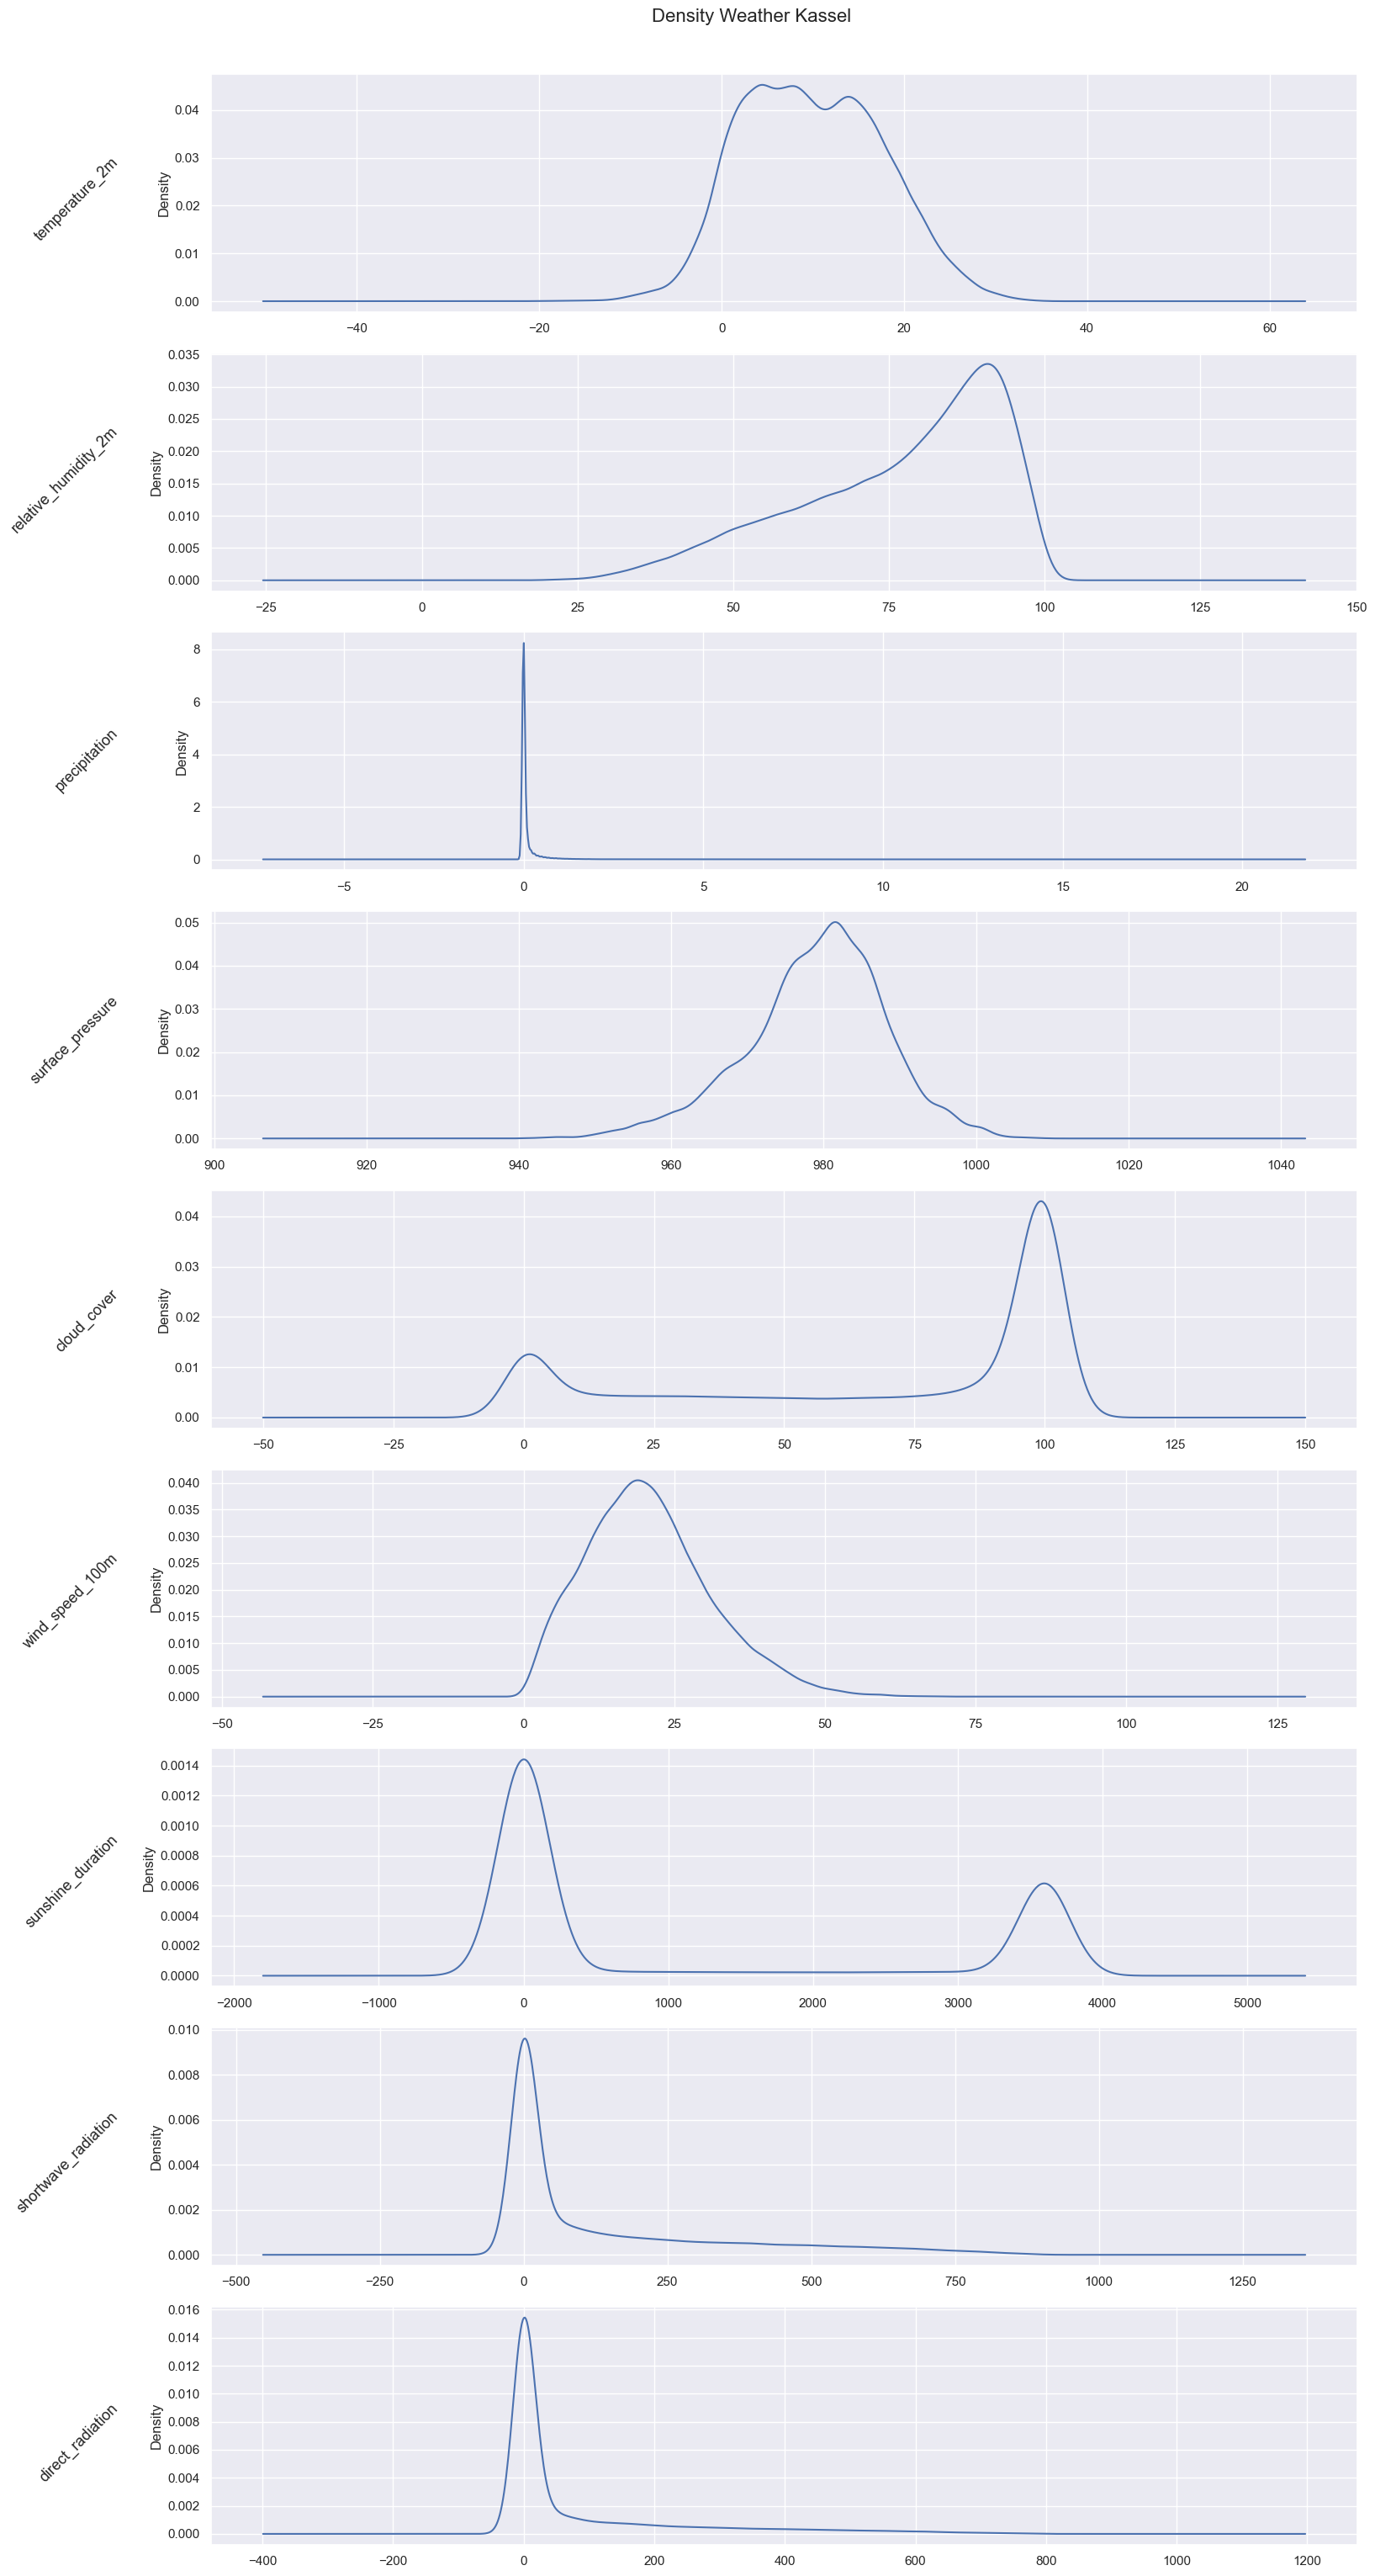

count    60408.000000
mean         9.912321
std          7.677677
min        -21.692999
25%          3.957000
50%          9.557000
75%         15.557000
max         35.357000
Name: temperature_2m, dtype: float64 

count    60408.000000
mean        76.712203
std         16.128366
min         16.331009
25%         65.969103
50%         80.881118
75%         89.832490
max        100.000000
Name: relative_humidity_2m, dtype: float64 

count    60408.000000
mean         0.086603
std          0.346211
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         14.500000
Name: precipitation, dtype: float64 

count    60408.000000
mean       979.023105
std          9.161473
min        940.595500
25%        973.834200
50%        979.879330
75%        985.118425
max       1009.012760
Name: surface_pressure, dtype: float64 

count    60408.000000
mean        67.450288
std         38.164129
min          0.000000
25%         32.000000
50%         90.000000
7

In [31]:
import seaborn as sns
sns.set()

rows = 9
fig, axs = plt.subplots(rows, figsize=(15, 30))
describe = []
for i, (cols_name, data) in enumerate(daily_weather_df.items()):

    describe.append(data.describe())
    weather_sorted = data

    weather_sorted.plot(ax = axs[i], kind = "density")

    # if weather_sorted.min() == 0.0:
    #     axs[i].set_xlim(0)

    y_pos = (rows - i - 0.5) / rows
    fig.text(0.0, y_pos, cols_name, ha='right', va='center', rotation=45, fontsize=13)


fig.tight_layout()
fig.suptitle("Density Weather Kassel", fontsize=16, y=1.02)

plt.show()
for i in describe:
    print(i, "\n")

## Mergee Data

In [11]:
merged_df = pd.concat(dfs_to_merge, axis=1, join='inner')
merged_df

,Price,Biomass,Hard Coal,Hydro,Lignite,Natural Gas,Nuclear,Other,Pumped storage generation,Solar,...,Wind onshore,temperature_2m,relative_humidity_2m,precipitation,surface_pressure,cloud_cover,wind_speed_100m,sunshine_duration,shortwave_radiation,direct_radiation
2024-10-30 00:00:00,100.71,0.101101,0.145455,0.045090,0.260219,0.243971,0.000000,0.049146,0.000022,0.0,...,0.107476,11.857000,92.975290,0.1,988.53284,100.0,17.640919,0.0,0.0,0.0
2024-10-29 23:00:00,103.09,0.097725,0.149445,0.044872,0.274110,0.243789,0.000000,0.046156,0.000599,0.0,...,0.102369,11.857000,92.051910,0.3,988.24380,100.0,17.519281,0.0,0.0,0.0
2024-10-29 22:00:00,118.08,0.095872,0.150584,0.047273,0.270704,0.255679,0.000000,0.046154,0.001140,0.0,...,0.097447,11.857000,91.440810,0.0,988.34015,100.0,16.167967,0.0,0.0,0.0
2024-10-29 21:00:00,124.05,0.095560,0.150384,0.044436,0.265195,0.268427,0.000000,0.046835,0.002805,0.0,...,0.096333,11.957001,90.537970,0.1,988.35297,100.0,18.557467,0.0,0.0,0.0
2024-10-29 20:00:00,140.60,0.093081,0.142999,0.047220,0.253702,0.278486,0.000000,0.044794,0.014459,0.0,...,0.097331,12.057000,89.644394,0.1,988.17300,100.0,18.179998,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-01 04:00:00,47.59,0.092527,0.148990,0.019701,0.282126,0.146368,0.138012,0.040888,0.003391,0.0,...,0.082545,4.557000,83.822650,0.0,975.15720,89.0,17.447933,0.0,0.0,0.0
2018-10-01 03:00:00,47.38,0.093932,0.146157,0.020071,0.286085,0.153114,0.140053,0.041441,0.003452,0.0,...,0.075943,4.207000,84.381560,0.0,975.30334,57.0,18.359999,0.0,0.0,0.0
2018-10-01 02:00:00,51.41,0.094656,0.139489,0.020001,0.286402,0.161350,0.142441,0.041791,0.003471,0.0,...,0.071471,4.457000,83.512050,0.0,975.52920,4.0,17.551615,0.0,0.0,0.0
2018-10-01 01:00:00,56.10,0.094738,0.142985,0.020278,0.285558,0.157544,0.142376,0.041972,0.003478,0.0,...,0.073151,4.907000,81.800370,0.0,975.68510,3.0,16.434305,0.0,0.0,0.0


## Standardization

In [12]:
standardize = True

if standardize:
    scaler = StandardScaler() #z-transformation
    z_merged_df = pd.DataFrame(
        scaler.fit_transform(merged_df.copy()),
        columns=merged_df.columns,
        index=merged_df.index,
    )

    actual_price_scaler = StandardScaler() #z-transformation
    z_actual_price_df = pd.DataFrame(
        actual_price_scaler.fit_transform(e_price_df.copy()),
        columns=e_price_df.columns,
        index=e_price_df.index,
    )

## Test/Evaluation/Train Set Split

In [13]:
def split(DATASET, TEST_SIZE = 0.18):

    SPLIT_DATE_EVAL = DATASET.index[int(TEST_SIZE * len(DATASET))]


    train = DATASET.loc[DATASET.index < SPLIT_DATE_EVAL]
    initial_test = DATASET.loc[DATASET.index >= SPLIT_DATE_EVAL]


    test_eval_split = int(len(initial_test) / 2)

    SPLIT_DATE_TEST = DATASET.index[int(TEST_SIZE * len(DATASET)) - test_eval_split - 1]

    test = initial_test.iloc[:test_eval_split]
    eval = initial_test.iloc[test_eval_split:]

    return train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST

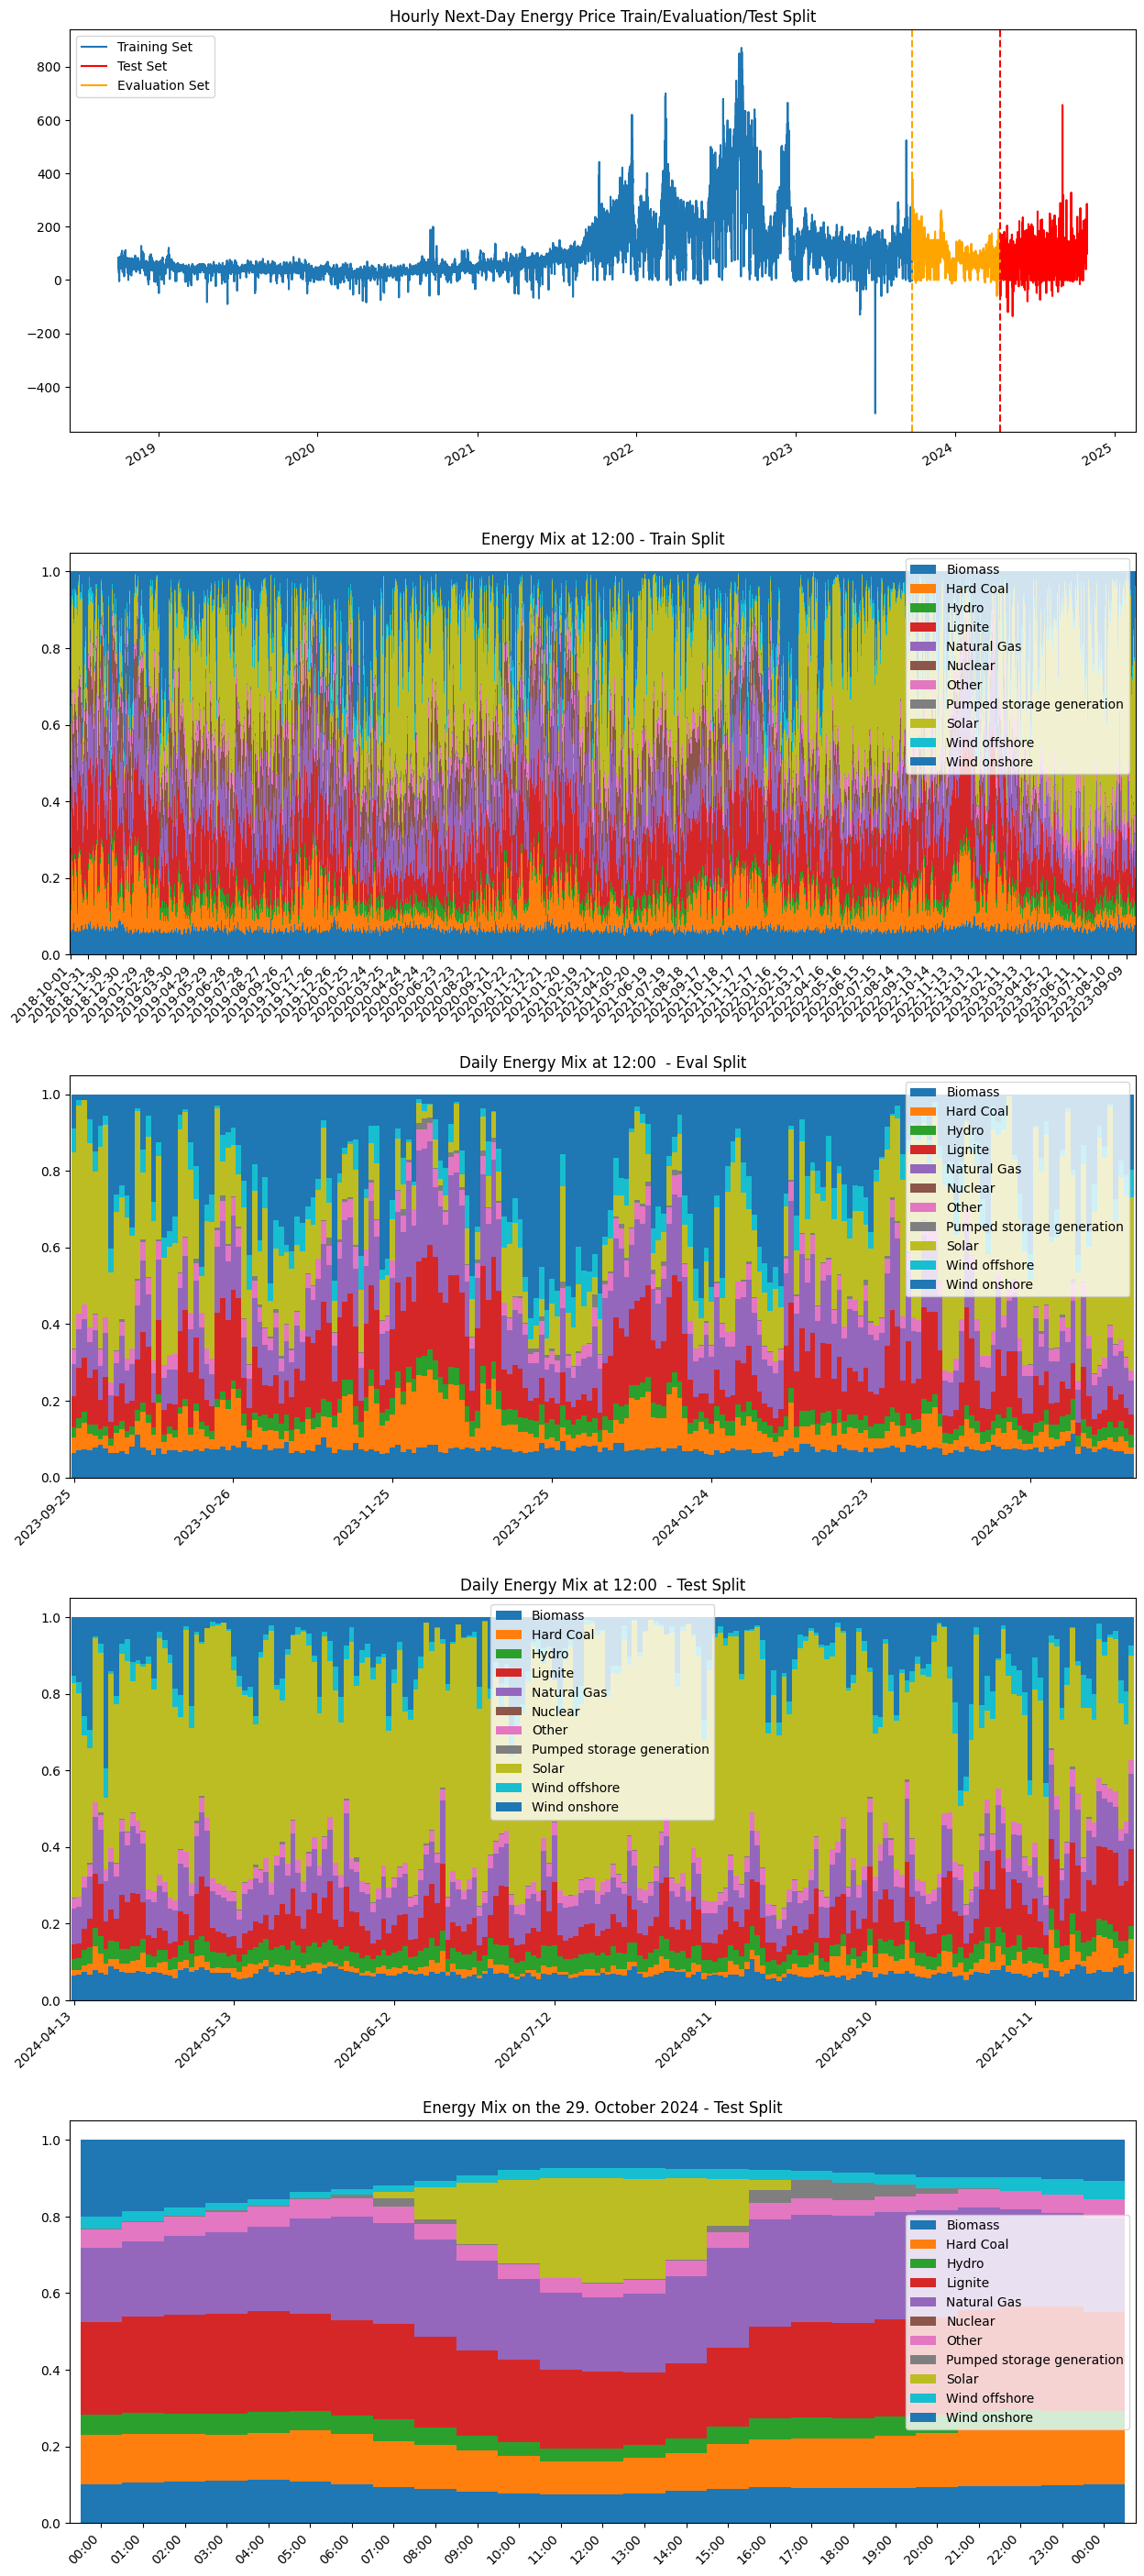

In [14]:
fig, axs = plt.subplots(nrows=5, figsize=(15, 40))

train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST = split(merged_df)

train["Price"].plot(ax=axs[0], label='Training Set', title='Hourly Next-Day Energy Price Train/Evaluation/Test Split')
test["Price"].plot(ax=axs[0], label='Test Set', color="red")
eval["Price"].plot(ax=axs[0], label='Evaluation Set', color="orange")
axs[0].axvline(SPLIT_DATE_EVAL, color='orange', ls='--')
axs[0].axvline(SPLIT_DATE_TEST, color='red', ls='--')
axs[0].legend(['Training Set', 'Test Set', 'Evaluation Set'])


cols = [
    "Biomass",
    "Hard Coal",
    "Hydro",
    "Lignite",
    "Natural Gas",
    "Nuclear",
    "Other",
    "Pumped storage generation",
    "Solar",
    "Wind offshore",
    "Wind onshore"
    ]

filtered_train = train[train.index.hour == 12][::-1]
filtered_train[cols].plot(ax=axs[1], kind="bar", stacked=True, title='Energy Mix at 12:00 - Train Split', width=1.0)
axs[1].set_xticks(np.arange(0, len(filtered_train), 30))
axs[1].set_xticklabels(filtered_train.index[::30].strftime('%Y-%m-%d'), rotation=45, ha='right')

filtered_eval = eval[eval.index.hour == 12][::-1]
filtered_eval[cols].plot(ax=axs[2], kind="bar", stacked=True, title='Daily Energy Mix at 12:00  - Eval Split', width=1.0)
axs[2].set_xticks(np.arange(0, len(filtered_eval), 30))
axs[2].set_xticklabels(filtered_eval.index[::30].strftime('%Y-%m-%d'), rotation=45, ha='right')

filtered_test = test[test.index.hour == 12][::-1]
filtered_test[cols].plot(ax=axs[3], kind="bar", stacked=True, title='Daily Energy Mix at 12:00  - Test Split', width=1.0)
axs[3].set_xticks(np.arange(0, len(filtered_test), 30))
axs[3].set_xticklabels(filtered_test.index[::30].strftime('%Y-%m-%d'), rotation=45, ha='right')

filtered_test = test.head(25)[::-1]
# print(filtered_test)
filtered_test[cols].plot(ax=axs[4], kind="bar", stacked=True, title='Energy Mix on the 29. October 2024 - Test Split', width=1.0)
axs[4].set_xticks(np.arange(0, len(filtered_test), 1))
axs[4].set_xticklabels(filtered_test.index.strftime('%H:%M'), rotation=45, ha='right')

plt.subplots_adjust(hspace=0.3)
plt.show()


## Feature Selection

In [15]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week

    german_holidays = holidays.Germany(years=[2018,2019,2020,2021,2022,2023,2024,2025])
    df['is_public_holiday'] = df.index.to_series().apply(lambda date: int(date in german_holidays))

    for window in [3, 6, 12]: # hours
        df[f'ma_{int(window)}_hours'] = df['Price'].rolling(window=window).mean()
        df[f'biomass_ma_{int(window)}_hours'] = df['Biomass'].rolling(window=window).mean()
        df[f'pumped_storage_generation_ma_{int(window)}_hours'] = df['Pumped storage generation'].rolling(window=window).mean()
        df[f'hard_coal_ma_{int(window)}_hours'] = df['Hard Coal'].rolling(window=window).mean()
        df[f'lignite_ma_{int(window)}_hours'] = df["Lignite"].rolling(window=window).mean()
        df[f'natural_gas_ma_{int(window)}_hours'] = df["Natural Gas"].rolling(window=window).mean()
        df[f'nuclear_ma_{int(window)}_hours'] = df["Nuclear"].rolling(window=window).mean()
        df[f'other_ma_{int(window)}_hours'] = df[ "Other"].rolling(window=window).mean()
        df[f'solar_ma_{int(window)}_hours'] = df['Solar'].rolling(window=window).mean()
        df[f'wind_offshore_ma_{int(window)}_hours'] = df["Wind offshore"].rolling(window=window).mean()
        df[f'wind_onshore_ma_{int(window)}_hours'] = df["Wind onshore"].rolling(window=window).mean()
    
    for window in [24, 72, 168]:  # 1 day 3 days, and 1 week
        df[f'ma_{int(window / 24)}_days'] = df['Price'].rolling(window=window).mean()
        df[f'biomass_ma_{int(window / 24)}_days'] = df['Biomass'].rolling(window=window).mean()
        df[f'pumped_storage_generation_ma_{int(window / 24)}_days'] = df['Pumped storage generation'].rolling(window=window).mean()
        df[f'hard_coal_ma_{int(window / 24)}_days'] = df['Hard Coal'].rolling(window=window).mean()

    return df

In [16]:
FEATURES = [
    "hour",
    "dayofyear",
    "dayofweek",

    "is_public_holiday",

    "ma_3_hours",
    "ma_6_hours",   
    "ma_1_days",
    # "ma_3_days",
    "ma_7_days",

# -- Energy Mix --
    "Biomass",
    "Hard Coal",
    "Hydro",
    "Lignite",
    "Natural Gas",
    "Nuclear",
    "Other",
    "Pumped storage generation",
    "Solar",
    "Wind offshore",
    "Wind onshore",

    # "biomass_ma_3_hours",
    # "biomass_ma_6_hours",
    # "biomass_ma_1_days",
    # "biomass_ma_3_days",
    # "biomass_ma_7_days",

    "pumped_storage_generation_ma_3_hours",
    "pumped_storage_generation_ma_6_hours",
    # "pumped_storage_generation_ma_1_days",
    # "pumped_storage_generation_ma_3_days",
    # "pumped_storage_generation_ma_7_days",
   
    # "hard_coal_ma_3_hours",
    # "hard_coal_ma_6_hours",
    # "hard_coal_ma_1_days",
    # "hard_coal_ma_3_days",
    # "hard_coal_ma_7_days",

    # "lignite_ma_3_hours",
    # "lignite_ma_6_hours",

    # "natural_gas_ma_3_hours",
    # "natural_gas_ma_6_hours",

    # "nuclear_ma_3_hours",
    # "nuclear_ma_6_hours",

    # "other_ma_3_hours",
    # "other_ma_6_hours",

    # "solar_ma_3_hours",
    # "solar_ma_6_hours",

    # "wind_offshore_ma_3_hours",
    # "wind_offshore_ma_6_hours",

    # "wind_onshore_ma_3_hours",
    # "wind_onshore_ma_6_hours",

#  -- Predicted Weather -- 
    # "pred_temperature_2m",
    # "pred_temperature_2m_previous_day1",

    # "pred_relative_humidity_2m",
    # "pred_relative_humidity_2m_previous_day1",

    # "pred_precipitation",
    # "pred_precipitation_previous_day1",
    # "pred_precipitation_previous_day2",

    # "pred_surface_pressure",
    # "pred_surface_pressure_previous_day1",

    # "pred_shortwave_radiation",
    # "pred_shortwave_radiation_previous_day1",

    # "pred_wind_speed_80m",
    # "pred_wind_speed_80m_previous_day1",

 #  -- Actual Weather -- 
    # "temperature_2m",
    # "relative_humidity_2m",
    # "precipitation",
    # "surface_pressure",
    # "cloud_cover",
    # "wind_speed_100m",
    # "sunshine_duration",
    # "shortwave_radiation",
    # "direct_radiation",
]

if standardize:
    train, eval, test, _, _ = split(z_merged_df)
    
train = create_features(train)
test = create_features(test)
eval = create_features(eval)

TARGET = "Price"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

X_val = eval[FEATURES]
y_val = eval[TARGET]

## Auto ML

In [17]:
default_params = {
    "base_score": 0.380924762889507,
    "early_stopping_rounds": 13,
    "max_depth": 40,
    "learning_rate": 0.06,
    "n_estimators": 140,
    "gamma": 0.9,
    "min_child_weight": 6,
    "subsample": 0.5719023844219375,
    "colsample_bytree": 0.8815691043681952,
}

In [18]:
def model_fit_and_predict(params):
    reg = xgb.XGBRegressor(**params)

    reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=None)
    pred = reg.predict(X_test)
    score = root_mean_squared_error(y_test, pred)
    return score

def objective(search_space):

    params = {
        "base_score":search_space.get("base_score", default_params["base_score"]),
        "early_stopping_rounds":search_space.get("early_stopping_rounds", default_params["early_stopping_rounds"]), 
        "max_depth":search_space.get("max_depth", default_params["max_depth"]),
        "learning_rate":search_space.get("learning_rate", default_params["learning_rate"]),
        "n_estimators":search_space.get("n_estimators", default_params["n_estimators"]),
        "gamma":search_space.get("gamma", default_params["gamma"]),
        "min_child_weight":search_space.get("min_child_weight", default_params["min_child_weight"]),
        "subsample":search_space.get("learning_rate", default_params["learning_rate"]),
        "colsample_bytree":search_space.get("colsample_bytree", default_params["colsample_bytree"]),
        "colsample_bynode":search_space.get("colsample_bynode", default_params["colsample_bynode"]),
        "colsample_bylevel":search_space.get("colsample_bylevel", default_params["colsample_bylevel"]),
        "reg_lambda":search_space.get("learning_rate", default_params["learning_rate"]),
    }

    rmse = model_fit_and_predict(params)
    
    return rmse

In [19]:
search = False

search_space = {
    # "base_score": hp.uniform("base_score", 0.38, 0.381),
    # "early_stopping_rounds": hp.choice("early_stopping_rounds", np.arange(3, 300, 1, dtype=int)),
    "max_depth": hp.choice("max_depth", np.arange(30, 50, 1, dtype=int)),
    # "learning_rate": hp.uniform("learning_rate", 0.025, 0.035),
    # "gamma": hp.uniform("gamma", 0.9, 0.9059588489958413),
    # "reg_lambda": hp.uniform("reg_lambda", 0.98, 1),
    # "colsample_bytree": hp.uniform("colsample_bytree", 0.85, 0.90),
    # "n_estimators": hp.choice("n_estimators", np.arange(100, 1000, 10, dtype="int")),
    # "min_child_weight": hp.choice("min_child_weight", np.arange(1, 10, 1, dtype="int")),
    # "subsample": hp.uniform("subsample", 0.5712784309398466, 0.572),
}

# Keeping track of the optimization history
trials = Trials()
best_search = {}
if search:

    # Run the Hyperopt optimization
    best_search = fmin(
        fn=objective, 
        space=search_space, 
        algo=tpe.suggest,
        max_evals=20, 
        trials=trials
    )

    score = model_fit_and_predict(best_search)
    print(f'RMSE Score on Test set: {score:.2f}\n')

print(f"base_score: {best_search.get("base_score", f"{default_params["base_score"]} (user default)")}, model default: 0.5")
print(f"early_stopping_rounds: {best_search.get("early_stopping_rounds", f"{default_params["early_stopping_rounds"]} (user default)")}, model default: 10")
print(f"max_depth: {best_search.get("max_depth", f"{default_params["max_depth"]} (user default)")}, model default: 6")
print(f"learning_rate: {best_search.get("learning_rate", f"{default_params["learning_rate"]} (user default)")}, model default: 0.3")
print(f"n_estimators: {best_search.get("n_estimators", f"{default_params["n_estimators"]} (user default)")}, model default: 100")
print(f"gamma: {best_search.get("gamma", f"{default_params["gamma"]} (user default)")}, model default: 0")
print(f"min_child_weight: {best_search.get("min_child_weight", f"{default_params["min_child_weight"]} (user default)")}, model default: 1")
print(f"subsample: {best_search.get("subsample", f"{default_params["subsample"]} (user default)")}, model default: 1")
print(f"colsample_bytree: {best_search.get("colsample_bytree", f"{default_params["colsample_bytree"]} (user default)")}, model default: 1")

base_score: 0.380924762889507 (user default), model default: 0.5
early_stopping_rounds: 13 (user default), model default: 10
max_depth: 40 (user default), model default: 6
learning_rate: 0.06 (user default), model default: 0.3
n_estimators: 140 (user default), model default: 100
gamma: 0.9 (user default), model default: 0
min_child_weight: 6 (user default), model default: 1
subsample: 0.5719023844219375 (user default), model default: 1
colsample_bytree: 0.8815691043681952 (user default), model default: 1


## Final Model

In [20]:
best_params = {
    "base_score": 0.380924762889507,
    "early_stopping_rounds": 20,
    "max_depth": 65,
    "learning_rate": 0.06,
    "n_estimators": 150,
    "gamma": 0.9,
    "min_child_weight": 6,
    "subsample": 0.5719023844219375,
    "colsample_bytree": 0.8815691043681952,
}

reg = xgb.XGBRegressor(**best_params)

reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=25)

y_predicted = reg.predict(X_test)

[0]	validation_0-rmse:0.66218
[25]	validation_0-rmse:0.17334
[50]	validation_0-rmse:0.09735
[75]	validation_0-rmse:0.08760
[100]	validation_0-rmse:0.08459
[125]	validation_0-rmse:0.08416
[149]	validation_0-rmse:0.08405


### Results

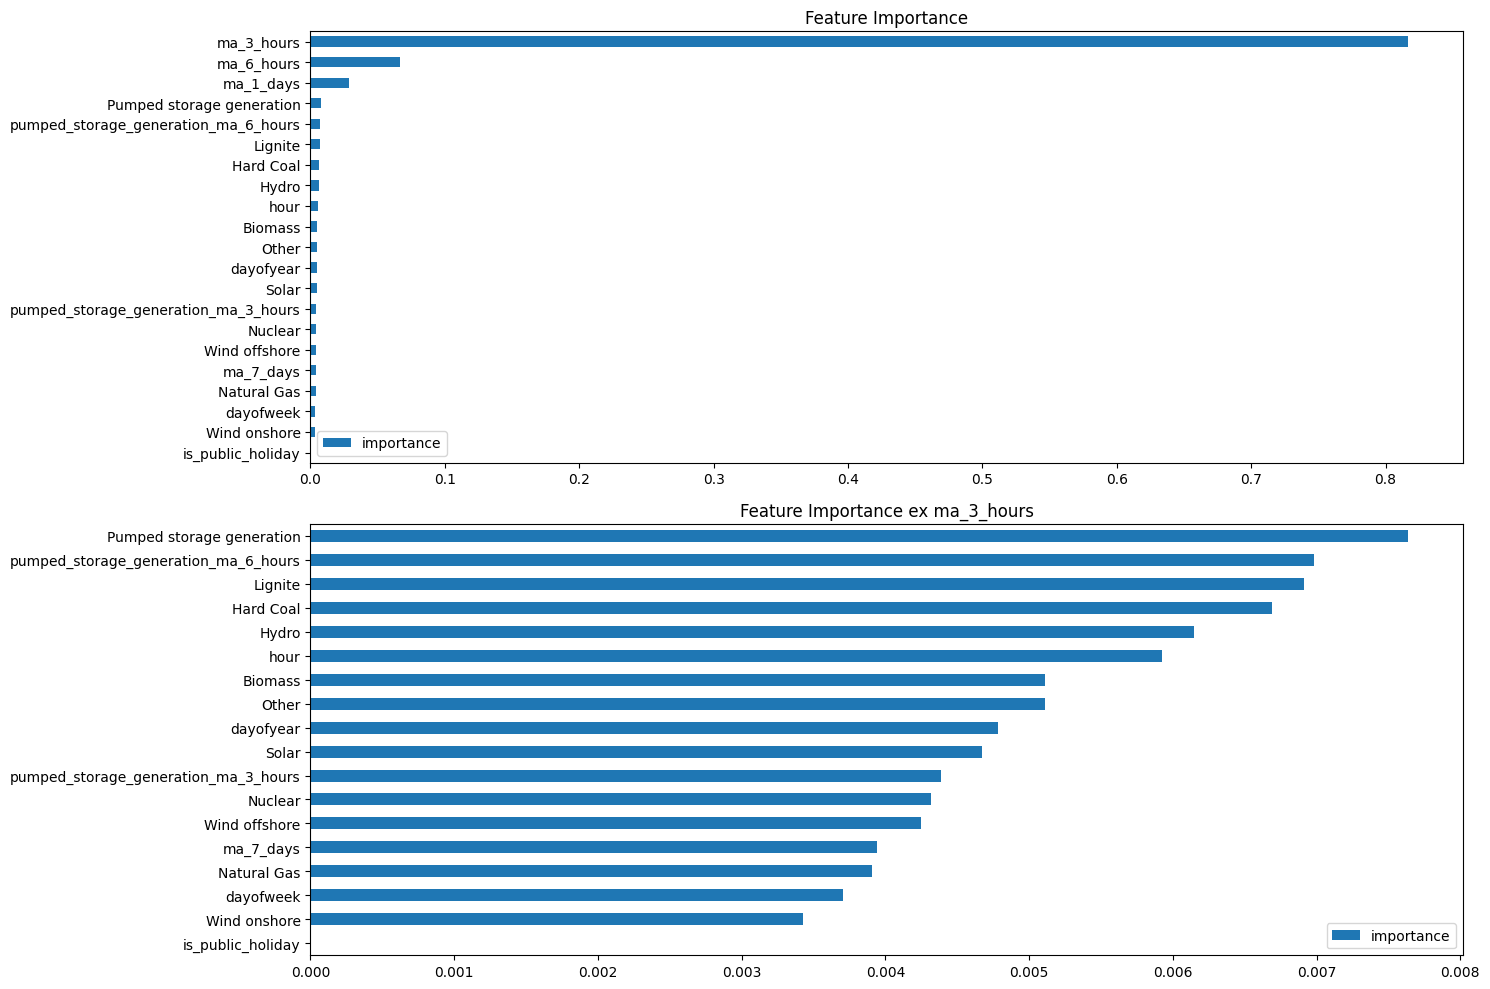

In [21]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 10))

idx = np.argsort(reg.feature_importances_)[::-1]
fi_sorted = reg.feature_importances_[idx]
fn_sorted = reg.feature_names_in_[idx]
idx_limited = np.argsort(reg.feature_importances_)[::-1][3:]
fi_sorted_limited = reg.feature_importances_[idx_limited]
fn_sorted_limited = reg.feature_names_in_[idx_limited]

fi = pd.DataFrame(data=fi_sorted,
             index=fn_sorted,
             columns=['importance'], )
fi.sort_values('importance').plot(ax=axs[0], kind='barh', title='Feature Importance')
fi = pd.DataFrame(data=fi_sorted_limited,
             index=fn_sorted_limited,
             columns=['importance'], )
fi.sort_values('importance').plot(ax=axs[1], kind='barh', title='Feature Importance ex ma_3_hours')
plt.tight_layout()
buf = io.BytesIO()
plt.savefig(buf, format='png')
plt.show()
plt.close()
buf.seek(0)

feature_importance_image = Image.open(buf)

In [22]:
if standardize:
    y_test = actual_price_scaler.inverse_transform([y_test])
    y_predicted = actual_price_scaler.inverse_transform([y_predicted])

    y_test = y_test.flatten()
    y_predicted = y_predicted.flatten()

test["Price"] = y_test
test["y_predicted"] = y_predicted

score = root_mean_squared_error(test[["Price"]], test[["y_predicted"]])
print(f'RMSE Score on Test set: {score:.6f}')

RMSE Score on Test set: 13.121562


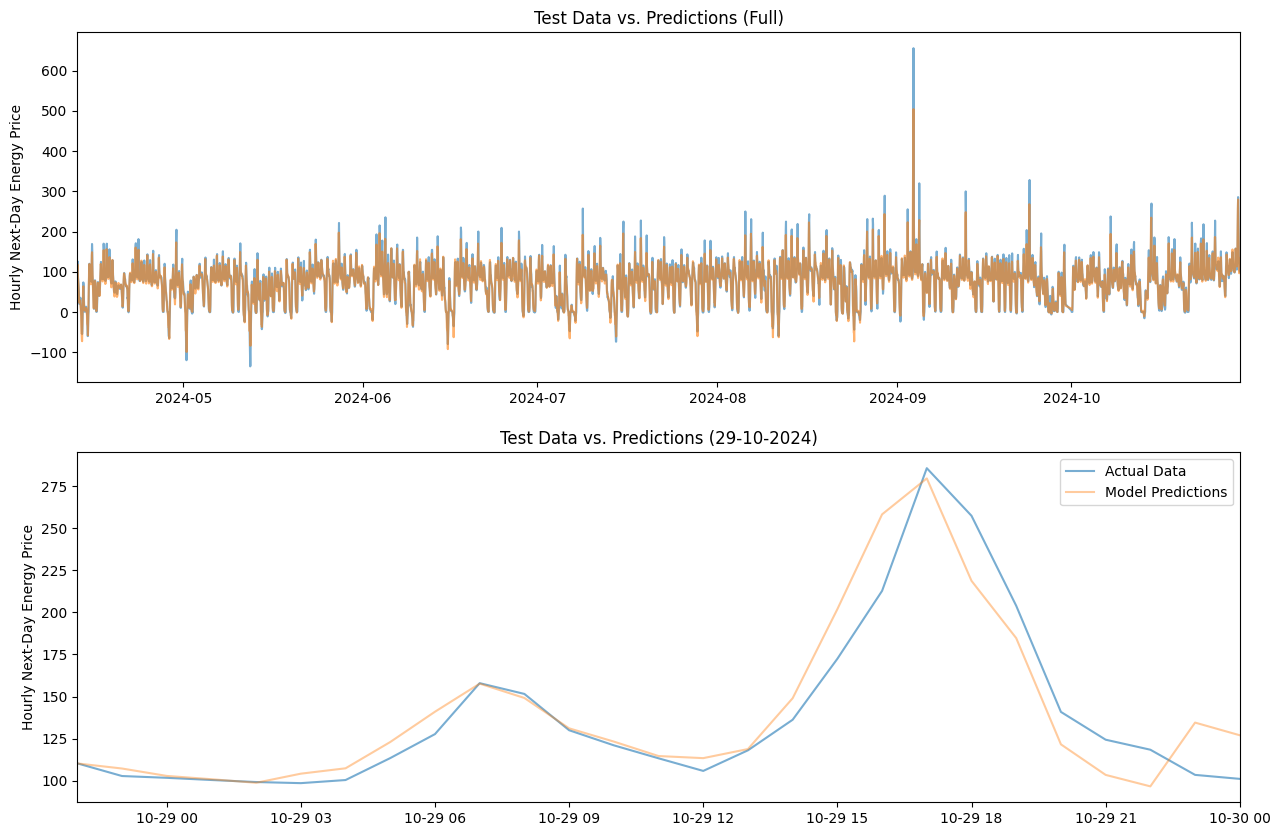

In [23]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 10))

WINDOW = test.copy()

axs[0].plot(WINDOW.index, WINDOW[TARGET],  alpha=0.6)
axs[0].plot(WINDOW.index, WINDOW["y_predicted"],  alpha=0.6)
axs[0].set_xlim(WINDOW.index.min(), WINDOW.index.max())
axs[0].set_ylabel("Hourly Next-Day Energy Price")
plt.legend(['Actual Data', 'Model Predictions'])    
axs[0].set_title('Test Data vs. Predictions (Full)')

WINDOW = test["2024-10-28 22:00:00":].copy()
axs[1].plot(WINDOW.index, WINDOW[TARGET],  alpha=0.6)
axs[1].plot(WINDOW.index, WINDOW["y_predicted"],  alpha=0.4)
axs[1].set_xlim(WINDOW.index.min(), WINDOW.index.max())
axs[1].set_ylabel("Hourly Next-Day Energy Price")
plt.legend(['Actual Data', 'Model Predictions'])    
axs[1].set_title('Test Data vs. Predictions (29-10-2024)')

buf = io.BytesIO()
plt.savefig(buf, format='png')
plt.show()
plt.close()
buf.seek(0)

ts_image = Image.open(buf)

### Specific Date Predictions

In [24]:
date = '2024-10-29'
predictions = test.loc[date, 'y_predicted']

# Display the result
print(predictions)

2024-10-29 23:00:00    134.501560
2024-10-29 22:00:00     96.577671
2024-10-29 21:00:00    103.400612
2024-10-29 20:00:00    121.556874
2024-10-29 19:00:00    184.719411
2024-10-29 18:00:00    218.793170
2024-10-29 17:00:00    279.704674
2024-10-29 16:00:00    258.321689
2024-10-29 15:00:00    201.962595
2024-10-29 14:00:00    148.994690
2024-10-29 13:00:00    118.761730
2024-10-29 12:00:00    113.366203
2024-10-29 11:00:00    114.611427
2024-10-29 10:00:00    123.210399
2024-10-29 09:00:00    131.089187
2024-10-29 08:00:00    149.139054
2024-10-29 07:00:00    157.665749
2024-10-29 06:00:00    140.958680
2024-10-29 05:00:00    122.958204
2024-10-29 04:00:00    107.319344
2024-10-29 03:00:00    104.128356
2024-10-29 02:00:00     98.709953
2024-10-29 01:00:00    100.834839
2024-10-29 00:00:00    102.792771
Name: y_predicted, dtype: float64


### Average absolute error by day

In [25]:
test['error'] = np.abs(test[TARGET] - test['y_predicted'])
test['date'] = test.index.date
test['error'].groupby(test['date']).mean()

date
2024-04-12    10.909361
2024-04-13    13.489293
2024-04-14     8.574735
2024-04-15    10.642334
2024-04-16     6.200784
                ...    
2024-10-26     5.395755
2024-10-27     5.209251
2024-10-28     5.018305
2024-10-29    12.422329
2024-10-30    25.932181
Name: error, Length: 202, dtype: float64

## Persisting Current Model and Features

In [26]:
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = f'./pickle/model_{score: .7g}_rmse_{ts}'
os.makedirs(output_dir, exist_ok=True)

model_dump_path = os.path.join(output_dir, "model.pickle")
with open(model_dump_path, "wb") as file:
    pickle.dump(reg, file)
hp_path = os.path.join(output_dir, "hyperparams.json")
with open(hp_path, "w") as file:
    best_params_native = {k: (int(v) if isinstance(v, (np.integer, int)) else float(v) if isinstance(v, (np.floating, float)) else v) for k, v in best_params.items()}
    json.dump(best_params_native, file, indent=4)
output_filename = 'plot_image.png'
ts_chart_path = os.path.join(output_dir, output_filename)
ts_image.save(ts_chart_path)

output_filename = 'feature_importance.png'
fi_path = os.path.join(output_dir, output_filename)
feature_importance_image.save(fi_path)

- Area - we see trend (assumption) stationary distribution \
- could try a linear transformation to see how bad it is \
- Find explanation for features 
- depth of data analysis

